__Uses PySurfer to get screenshot images of bootstrapped regression analyses (thresholded at 2) overlayed on Yeo annotation and with bootstrapped mediation analyses thresholded (bootstrap score=1.96) outlines__

In [1]:
%matplotlib inline

In [2]:
import os
from surfer import Brain
import matplotlib.pyplot as plt
import nibabel.freesurfer as fs
import numpy as np

In [3]:
reg_min=2
reg_max=6
def get_image(np_name,meas,anal,metric,view,hemi):
    #import overlay data, setting nan values to 0
    regfile=('{}_{}_{}_{}_{}.curv'
             .format(hemi,meas,np_name,'pcorr_cog',metric))
    reg_data=fs.read_morph_data(
        '../curvoverlays/'+regfile)
    reg_data[np.isnan(reg_data)]=0
    brain = Brain('fsaverage',hemi,'inflated',
                  cortex="grey", 
                  background="white")
    #add image overlay 
    #and hide colorbar
    brain.add_overlay(reg_data,
                      min=reg_min,
                      max=reg_max,
                      name='reg')
    brain.overlays["reg"].pos_bar.visible = False
    brain.overlays["reg"].neg_bar.visible = False
    #add Yeo annotation
    brain.add_annotation(
        'Yeo2011_7Networks_N1000',
        alpha=.3)
    brain.add_annotation(
        'Yeo2011_7Networks_N1000',
        borders=False,
        alpha=.2,
        remove_existing=False)
    #add mediation results as outline 
    #from annotation created 
    #by mri_surfcluster
    medfile=('{}_{}_{}_{}_{}_cluster.annot'
             .format(hemi,meas,np_name,'mediate',metric))
    med_annot=fs.read_annot(
        '../curvoverlays/'+medfile)
    #makes all labels black rgb value
    med_annot[1][:,0:-2]=0 
    brain.add_annotation(
        (med_annot[0],med_annot[1]),
        alpha=1,
        remove_existing=False)
    #make image
    brain.show_view(view)
    #get image pixel voxels
    brain_image=brain.screenshot_single() 
    brain.close()
    #remove whitespace
    whitepixels=np.all(
        brain_image==np.array([255,255,255]),
        axis=-1)
    rows=[i for i,x in enumerate(
        ~np.all(whitepixels,axis=1)) if x]
    columns=[i for i,x in enumerate(
        ~np.all(whitepixels,axis=0)) if x]
    return brain_image[np.ix_(rows,columns)]

In [4]:
measure_list=['area','thickness']
np_name_list=['ExFunction','Memory']
hemilist=['lh','rh']
viewlist=['lateral','medial']

###### Make snapshot images

In [5]:
%%capture
subplots=[{'hemi':hemi,
           'meas':meas,
           'np_name':np_name,
           'anal':'pcorr_cog',
           'metric':'boot_score',
           'view':view}
          for np_name in np_name_list 
          for hemi in hemilist 
          for meas in measure_list 
          for view in viewlist]
subplots_images=[(i,get_image(**x)) 
                 for i,x
                 in enumerate(subplots)]

#### Put images into a grid of matplotlib subplots

In [6]:
%%capture
wspace=.05
hspace=.05
f,axes=plt.subplots(4,4,
    gridspec_kw={'wspace':wspace,
                 'hspace':hspace})
for i,image in subplots_images:
    f.axes[i].imshow(image,
                     extent=(-1,2,-1,1),
                     aspect=1)
    f.axes[i].axis('off')

#### Draw lines separating surface area/thickness and np measure

In [7]:
%%capture
#[*left*(x_left), *bottom* (y_bottom),*width*,*height*]
vline=f.add_axes([0,0,1,1])
hline=f.add_axes([0,0,1,1])
vline.axvline(x=.5+wspace/4,
              ymax=.85,ymin=.15,
              linewidth=2,
              color='black')
hline.axhline(y=.5+hspace/4,
              xmax=.85,xmin=.15,
              linewidth=2,
              color='black')
vline.axis('off')
hline.axis('off')

##### Draw color bar

In [8]:
%%capture
#[*left*(x_left), *bottom* (y_bottom),*width*,*height*]
#had to adjust trial/error for tick label positions..
#may want ot do more systematically in future
cbar_axes = (f.add_axes([.15, .1, .3, .02]),
             f.add_axes([.57, .1, .3, .02]))
cbar = np.atleast_2d(np.linspace(-5, 5, 300))
for ax, cmap in zip(cbar_axes,
                    ["PuBu", "OrRd_r"]):
    ax.pcolormesh(cbar, cmap=cmap, 
                  rasterized=True)
    ax.set(xticks=np.linspace(0, 300, 3), 
           yticks=[])
    ax.xaxis.tick_bottom()
cbar_axes[0].set_xticklabels(
    [-6, -4, -reg_min],ha='center')
cbar_axes[1].set_xticklabels(
    [reg_min, 4, 6],ha='center')

#### Make labels for each facet

In [9]:
labelcoords=[(.3,.95,'center','top','horizontal'),
           (.72,.95,'center','top','horizontal'),
           (0.1,.32,'left','center','vertical'),
           (0.1,.75,'left','center','vertical')]
labelnames=['Surface Area',
            'Thickness',
            'Memory',
            'Executive Function']
label_params=[tuple([n])+(p) 
              for p,n 
              in zip(labelcoords,labelnames)]

In [10]:
for s,x,y,ha,va,rot in label_params:
    f.text(s=s,x=x,y=y,ha=ha,va=va,
           rotation=rot)

#### save figure and draw on notebook

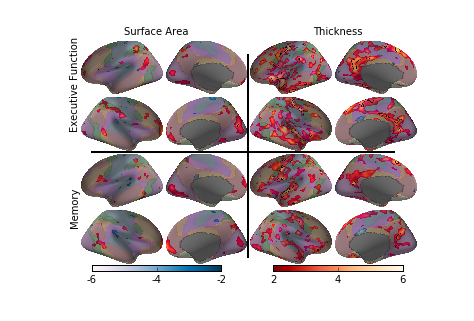

In [11]:
f.savefig('../figures/'
          'wholebrain_mediation_regression_4_17_18.png',
          dpi=300)
f